In [1]:
import os
from datetime import datetime
import numpy as np
from netCDF4 import Dataset
import netCDF4
import matplotlib.pyplot as plt
from wrf import to_np, getvar, CoordPair, vertcross, latlon_coords, interplevel, get_cartopy,  xy_to_ll, ll_to_xy, smooth2d
import wrf
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import glob
import xarray as xr
import pygrib
from scipy.ndimage import gaussian_filter
from matplotlib.cm import get_cmap
from statistics import multimode, mode
from scipy.ndimage import label, find_objects

In [3]:
################### Saving plots option ##################

save = True

########### If you want to save plots, specify the subdirectory you want them in ###########

plotsdir = "/home/jupyter-sdsmit12@ncsu.edu/WRF_project_1/wwrf/2017-01-09/plots/"
print(plotsdir)
########### what pressure level do we want to view with our plots, if any ###

contour = True

if contour == True:
    p_level = 850
    
############ Gravity ###########
g0 = 9.80665

######## Number of vertical levels in GRIB data #########

num_levels = 37

####### The map projection you would like to use ########

projection=ccrs.PlateCarree(central_longitude=0) 

################ Set bounds for plotting #################

wlon = -140
elon = -110
slat = 20
nlat = 45

############################# Set ranges and intervals for plotting ###############################

if p_level == 1000:
    levels = np.arange(-180,180,30)
    q_levels = np.arange(0, 22, 1)
    wnd_levels = np.arange(0, 30, 1)
elif p_level == 850:
    levels = np.arange(1000, 2000, 50)
    q_levels = np.arange(0, 16, .5)
    wnd_levels = np.arange(10, 51, 1)   
    kt_levels = np.arange(20,70,5)
elif p_level == 700:
    levels = np.arange(2350, 3150, 30)
    q_levels = np.arange(0, 12, .5)
    wnd_levels = np.arange(10, 50, 1) 
elif p_level == 500:
    levels = np.arange(4000, 6000, 60)
    q_levels = np.arange(0, 16, .5)
    wnd_levels = np.arange(10, 65, 1) 
elif p_level == 300:
    levels = np.arange(8200, 9600, 120)
    wnd_levels = np.arange(20, 90, 1) 
elif p_level == 200:
    levels = np.arange(10800,12300, 120)
    wnd_levels = np.arange(20, 90, 1) 
    
########### Define the colors in the desired sequence for IVT: ###########

ivt_colors = ['#FFFF00', '#FFEE00','#FFDC00', '#FFB700',
          '#FFA300', '#FF9000', '#FF7D00', '#FF6800',
          '#FF5200', '#C70039','#900C3F', (.88,.24,.69)]

############## Create a colormap using ListedColormap #################

ivt_cmap = mcolors.ListedColormap(ivt_colors)

ivt_levels = np.arange(250,1150,1)

pmsl_levels = np.arange(960, 1060, 4)
# dark brown for state/coastlines
dark_brown = (0.4, 0.2, 0)

/home/jupyter-sdsmit12@ncsu.edu/WRF_project_1/wwrf/2017-01-09/plots/


In [4]:
################## Path to where ERA files reside ######################################

era = "/scratch/sawyer/ERA5/2017-01-09/wrf_comp/adaptor.mars.internal-1693840978.8307157-5321-11-c1655257-c1c0-4771-9ebd-f6bfce6f1a9a.grib"
#era_mslp = "/scratch/sawyer/ERA5/2017-01-09/wrf_comp/era5_mslp/adaptor.mars.internal-1694533383.8307068-11875-7-34e3326b-7257-4f32-aed0-8f0410a7b5a0.grib"
# Lets see whats in our GRIB file

grbs = pygrib.open(era)
#grbss = pygrib.open(era_mslp)
grib = grbs.select(name='Specific humidity')[0]

# Loop over all messages in the GRIB file
for grb in grbs:
    print(f"Name: {grb.name}, Level: {grb.level}")

# Close the GRIB file
#grbss.close()

# Get the data and latitudes/longitudes
coords = grbs.select(name='Geopotential', level=p_level)[0]
lats, lons = coords.latlons()

#mslp_coords = grbss.select(name='Mean sea level pressure')[0]
#mslp_lats, mslp_lons = mslp_coords.latlons()

In [5]:
'''
mslp = grbss.select(name='Mean sea level pressure')[0].values#,time = hours, date = dates)[0].values
#print(mslp)
# Select the MSLP messages
mslp_messages = [msg for msg in grbss if msg.name == 'Mean sea level pressure']
print(mslp_messages)
# Sort the messages by their timestamps for sequential plotting
mslp_messages.sort(key=lambda x: (x.dataDate, x.dataTime))
'''


"\nmslp = grbss.select(name='Mean sea level pressure')[0].values#,time = hours, date = dates)[0].values\n#print(mslp)\n# Select the MSLP messages\nmslp_messages = [msg for msg in grbss if msg.name == 'Mean sea level pressure']\nprint(mslp_messages)\n# Sort the messages by their timestamps for sequential plotting\nmslp_messages.sort(key=lambda x: (x.dataDate, x.dataTime))\n"

In [6]:
"""
This function computes Integrated Vapor Transport (IVT) from wrfout files
"""
def calculate_IVT(ua,va,p,mr):
   
    
    uflux_l = []
    vflux_l = []
    for m in range(0,len(mr)-2):
        layer_diff = p[m,:,:]-p[m+1,:,:]
        ql = (mr[m+1,:,:]+mr[m,:,:])/2
        ul = (ua[m+1,:,:]+ua[m,:,:])/2
        vl = (va[m+1,:,:]+va[m,:,:])/2
        qfl = (ql/9.80665)*layer_diff
        uflux= ul * qfl
        vflux = vl * qfl
        uflux_l.append(uflux)
        vflux_l.append(vflux)

    uflux_l=np.asarray(uflux_l)
    vflux_l=np.asarray(vflux_l)
    uIVT = np.sum(uflux_l, axis = 0)
    vIVT = np.sum(vflux_l, axis = 0)
    IVT=np.sqrt(uIVT**2+vIVT**2)
    #IVT_tot=xr.DataArray(IVT_tot,dims=['lat','lon'])
    
    return IVT

def calculate_centroid_lon(component, lon):
    lon_slice = lon[slices[1]]
    centroid_lon = np.mean(lon_slice)
    return centroid_lon


"""
This function computes Integrated Vapor Transport (IVT) using data in GRIB format
"""
def calculate_ERA_IVT():
    
    # Get the shape of the data (latitude, longitude, level)
    first = len(grib.values[:])
    second = len(grib.values[0,:])

    # Create an empty array to store the specific humidity, wind components and pressure at every level
    pressure_array = np.zeros([num_levels, first, second])
    sp_hum_array = np.zeros([num_levels, first, second])
    uwnd_array = np.zeros([num_levels, first, second])
    vwnd_array = np.zeros([num_levels, first, second])
    #print(sp_hum_array.shape)
    # Loop over all levels and extract the specific humidity
    for i, level in enumerate(grbs.select(name='Specific humidity', time = hours, date = dates)):
        # Extract the specific humidity for this level
        sp_hum = level.values
        # Store the specific humidity in the array
        pressure_array[i,:,:] = level['level']*100
        sp_hum_array[i,:,:] = sp_hum
    for i, level in enumerate(grbs.select(name='U component of wind', time = hours, date = dates)):

        u_wind = np.abs(level.values)
        uwnd_array[i,:,:] = u_wind

    for i, level in enumerate(grbs.select(name='V component of wind', time = hours, date = dates)):

        v_wind =np.abs(level.values)
        vwnd_array[i,:,:] = v_wind 
        
    uflux_l = []
    vflux_l = []

    for m in range(0,len(sp_hum_array)-2):
        layer_diff = pressure_array[m,:,:]-pressure_array[m+1,:,:]
        ql = (sp_hum_array[m+1,:,:]+sp_hum_array[m,:,:])/2
        ul = (uwnd_array[m+1,:,:]+uwnd_array[m,:,:])/2
        vl = (vwnd_array[m+1,:,:]+vwnd_array[m,:,:])/2
        qfl = (ql/9.80665)*layer_diff
        uflux= ul * qfl
        vflux = vl * qfl
        uflux_l.append(uflux)
        vflux_l.append(vflux)

    uflux_l=np.asarray(uflux_l)
    vflux_l=np.asarray(vflux_l)
    uIVT = np.sum(uflux_l, axis = 0)
    vIVT = np.sum(vflux_l, axis = 0)
    IVT_tot=np.sqrt(uIVT**2+vIVT**2)
    IVT_tot=xr.DataArray(IVT_tot,dims=['lat','lon'])
    
    return IVT_tot

In [15]:
# Define your date-time bounds
#start_bound = datetime.strptime("2017-01-06 12:00", "%Y-%m-%d %H:%M")
start_bound = datetime.strptime("2017-01-08 00:00", "%Y-%m-%d %H:%M")
end_bound = datetime.strptime("2017-01-08 00:00", "%Y-%m-%d %H:%M")


ensemble member:  ctrl
/scratch/sawyer/wwrf/2017-01-09/ctrl/wrfout_d01_2017-01-08_00:00:00
title time:  2017-01-08 0000
dates type:  <class 'int'>
20170108
hours type:  <class 'int'>
0


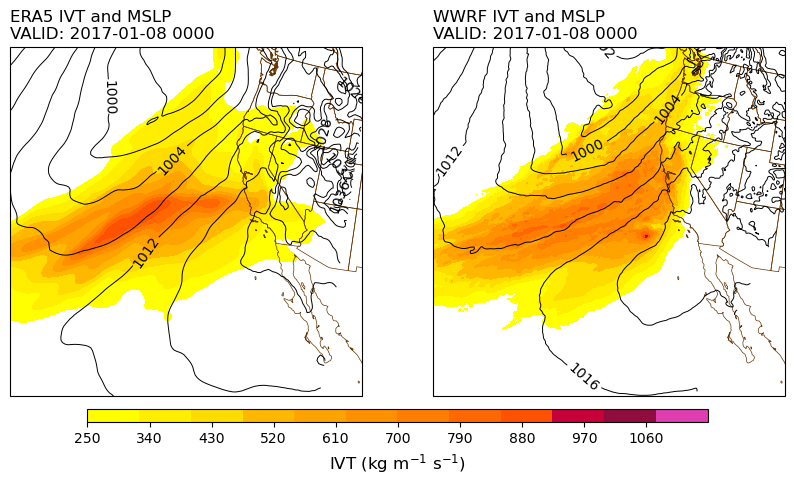

In [16]:
# Loop through dictionary
for var_name, dir_path in directories.items():
    # First, filter the filenames that contain 'wrfout_d01' and then sort them
    sorted_files = sorted([filename for filename in os.listdir(dir_path) if domain in filename])
    #print(sorted_files)
    ensemble_member = var_name
    print("ensemble member: ", var_name)
    
    for filename in sorted_files:
        # Extract date-time from filename
        date_time_str = filename.split('_')[2] + ' ' + filename.split('_')[3]
        #print(date_time_str)# Adjust indices if filename structure is different
        current_datetime = datetime.strptime(date_time_str, "%Y-%m-%d %H:%M:%S")
        #print(current_datetime)# Check if the current_datetime is within bounds
        if start_bound <= current_datetime <= end_bound:
            file_path = os.path.join(dir_path, filename)
            print(file_path)
            
            with Dataset(file_path, 'r') as ncfile:

                Time=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
                timestr=(str(Time))

                # Set up one time string for plot titles, another for file names

                titletime=(timestr[0:10]+' '+timestr[11:13]+timestr[14:16])
                filetime=(timestr[0:10]+'_'+timestr[11:13])
                print("title time: ",titletime)
               
                dates = int(timestr[0:10].replace('-', ''))
                print("dates type: ",type(dates))
                print(dates)
                # Multiply by 100 to get time in correct format for grib files
                hours = int(timestr[11:13]) * 100
                print("hours type: ",type(hours))
                print(hours)
                
                # Get all the variables we need from wrf
                p = getvar(ncfile, "pressure")*100
                ua = getvar(ncfile, "ua")
                va = getvar(ncfile, "va")
                wspd = getvar(ncfile, "wspd_wdir")[0,:]
                mixing_ratio = ncfile['QVAPOR'][0,:,:,:]
                slp = getvar(ncfile,'slp')
                # Smooth the sea level pressure since it tends to be noisy near complex terrain
                # The smoother can be adjusted, experiment with different values
                smooth_slp = smooth2d(slp, 3, cenweight=4)
                #height = getvar(ncfile, "z")
                #heights = interplevel(height, p, p_level)
                #wrf_windsp = interplevel(wspd, p, p_level)

                # Get the lat/lon coordinates and fix lons around dateline from wrf output
                wrf_lats, wrf_lons = latlon_coords(p)

                new_lons = np.where(wrf_lons > 0, wrf_lons - 360, wrf_lons)
                
                # Select MSLP variable
                mslp = grbss.select(name='Mean sea level pressure',time = hours, date = dates)[0].values
                
                mslp =mslp / 100 #Convert from Pa to hPa
                
                #calculate IVT
                
                IVT_tot = calculate_ERA_IVT()
                wrf_ivt = calculate_IVT(ua,va,p,mixing_ratio)
                
                # Create a figure and axis
                fig, ax = plt.subplots(1,2,figsize=(10, 6),subplot_kw={'projection': ccrs.LambertConformal()})
                # Plot the identified atmospheric rivers as colored regions
                ax[0].set_extent([wlon,elon,slat,nlat])
                ax[0].add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor=dark_brown)#Add coastlines)
                ax[0].add_feature(cfeature.STATES, linewidth=0.5,edgecolor=dark_brown)
                ax[1].set_extent([wlon,elon,slat,nlat])
                ax[1].add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor=dark_brown)#Add coastlines)
                ax[1].add_feature(cfeature.STATES, linewidth=0.5,edgecolor=dark_brown)
                # Set figure size
                ##################################################################################
                # Plot the labeled atmospheric rivers with a single color (e.g., blue)
                cs1= ax[0].contour(mslp_lons, mslp_lats, mslp, colors = 'black',levels=pmsl_levels, linewidths=.7, transform=ccrs.PlateCarree()) 
                plt.clabel(cs1, fmt='%1.0f', inline=True,levels=pmsl_levels)
                cs = ax[0].contourf(lons, lats, IVT_tot, levels=ivt_levels, cmap=ivt_cmap,transform=ccrs.PlateCarree())
                cs2 = ax[1].contourf(new_lons, wrf_lats,wrf_ivt, levels=ivt_levels, cmap=ivt_cmap,transform=ccrs.PlateCarree())
                cs3 = ax[1].contour(new_lons, wrf_lats,smooth_slp, levels=pmsl_levels, colors = 'black',linewidths=.7, transform=ccrs.PlateCarree())
                plt.clabel(cs3, fmt='%1.0f', inline=True,levels=pmsl_levels)# Add a colorbar
                
                cbar = plt.colorbar(cs, ax=ax, orientation="horizontal", pad=.03, shrink=.8, aspect=50)
                cbar.set_label("IVT (kg m$^{-1}$ s$^{-1}$)", fontsize = 12)
                '''
                gl = ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
                gl.top_labels=False   # suppress top grid labels
                gl.right_labels=False # suppress right grid labels
                gl2 = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
                gl2.top_labels=False   # suppress top grid labels
                gl2.right_labels=False # suppress right grid labels
                '''
                # Set plot title and labels (customize as needed)
                ax[0].set_title(f'ERA5 IVT and MSLP\nVALID: {titletime}',loc='left')
                #ax[0].set_xlabel('Longitude')
                #ax[0].set_ylabel('Latitude')
                
                                # Set plot title and labels (customize as needed)
                ax[1].set_title(f'WWRF IVT and MSLP\nVALID: {titletime}',loc='left')
                #ax[1].set_title("",loc="right")
                #ax[1].set_xlabel('Longitude')
                #ax[1].set_ylabel('Latitude')
                '''
                # Show the plot
                if save == True:
                    # Create separate plot file and save as .png, then show and close
                    outTPlotName= str(filetime)+'_ERA5.png'
                    fig.savefig(plotsdir+'/'+outTPlotName)
                    plt.show()
                plt.close(fig)
                #plt.savefig('AR_Object')
                
                #plt.close(fig)
                '''

In [ ]:
ctrl_avg_ivt = round(np.mean(np.array(ctrl_mean_ivt)))
ctrl_std = round(np.std(np.array(ctrl_mean_ivt)))
ctrl_median = round(np.median(np.array(ctrl_mean_ivt)))
print("ctrl mean ivt: ",ctrl_avg_ivt)
print("ctrl std: ",ctrl_std)


p3_avg_ivt = round(np.mean(np.array(p3_mean_ivt)))
p3_std = round(np.std(np.array(p3_mean_ivt)))
print("p3 mean ivt: ",p3_avg_ivt)
print("p3 std: ", p3_std)

p3mom_avg_ivt = round(np.mean(np.array(p3mom_mean_ivt)))
p3mom_std = round(np.std(np.array(p3mom_mean_ivt)))
print("p3 3-mom mean ivt: ",p3mom_avg_ivt)
print("p3 3-mom std: ",p3mom_std)

wsm6_avg_ivt = round(np.mean(np.array(wsm6_mean_ivt)))
wsm6_std = round(np.std(np.array(wsm6_mean_ivt)))
print("wsm6 mean ivt: ",wsm6_avg_ivt)
print("wsm6 std: ",wsm6_std)
'''
ensemble_99 = round(np.percentile(ensemble_ivt, 99),2)
print(ensemble_99)
ensemble_98 = round(np.percentile(ensemble_ivt, 98),2)
print(ensemble_98)
ensemble_97 = round(np.percentile(ensemble_ivt, 97),2)
print(ensemble_97)
ensemble_96 = round(np.percentile(ensemble_ivt, 96),2)
print(ensemble_96)
ensemble_95 = round(np.percentile(ensemble_ivt, 95),2)
print(ensemble_95)
'''

In [ ]:
'''
import csv
# Create a dictionary with these percentiles
percentiles_dict = {
    "95th_percentile": ensemble_95,
    "96th_percentile": ensemble_96,
    "97th_percentile": ensemble_97,
    "98th_percentile": ensemble_98,
    "99th_percentile": ensemble_99
}

# Write the dictionary to a CSV
with open('AR_stats.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=percentiles_dict.keys())
    writer.writeheader()
    writer.writerow(percentiles_dict)
'''

In [ ]:
datafiles.sort()
#print(datafiles)
numfiles=len(datafiles)
print(numfiles)

for i in range(0,numfiles):
    ncfile = Dataset(datafiles[i])

    Time=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))

    # Set up one time string for plot titles, another for file names

    titletime=(timestr[0:10]+' '+timestr[11:13]+timestr[14:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])
    print(titletime)
    # Get all the variables we need

    p = getvar(ncfile, "pressure")*100
    ua = getvar(ncfile, "ua")
    va = getvar(ncfile, "va")
    mixing_ratio = ncfile['QVAPOR'][0,:,:,:]

    IVT_tot = calculate_IVT(ua,va,p,mixing_ratio)
    ########## WWRF longitude fix ########################
    lats, lons = latlon_coords(p)
    lon =np.where(lons > 0, lons - 360, lons)
    
    # Step 3: Apply the threshold
    threshold = 250
    atmospheric_rivers = IVT_tot > threshold


    # Step 4: Identify contiguous regions (connected components) using scipy.ndimage.label
    labeled_rivers, num_features = label(atmospheric_rivers)


    # Step 5: Filter atmospheric rivers based on geometric thresholds
    # Define your geometric thresholds here (width and length criteria)
    min_width = 122 # Minimum width threshold (number of grid cells)
    min_length = 111# Minimum length threshold (number of grid cells)
    min_ivt_threshold = 250  # Minimum IVT threshold (kg/m/s)
    '''
    filtered_rivers = np.zeros_like(labeled_rivers)
    for label_value in range(1, num_features + 1):

        component = labeled_rivers == label_value

        # Use find_objects to get the bounding box of each component
        slices = find_objects(component)[0]

        # Calculate width and length of the component
        width = slices[1].stop - slices[1].start
        length = slices[0].stop - slices[0].start

        # Check if the component meets the width and length thresholds
        if width >= min_width and length >= min_length:
            filtered_rivers[component] = label_value

    # Update the labeled_rivers with the filtered regions

    labeled_rivers, num_features = label(filtered_rivers)
    '''
    # Variables to keep track of the easternmost AR object
    easternmost_centroid_lon = float(10000)  # Initialize with a large value
    easternmost_label = None

    for label_value in range(1, num_features + 1):
        component = labeled_rivers == label_value

        # Use find_objects to get the bounding box of each component
        slices_list = find_objects(component)

        # Check if there are valid bounding boxes
        if slices_list:
            slices = slices_list[0]

            # Calculate width and length of the component
            width = slices[1].stop - slices[1].start
            length = slices[0].stop - slices[0].start

            # Calculate centroid longitude of the AR
            cent_lon = calculate_centroid_lon(component, lon)

            # Check if the component meets the width and length thresholds
            if width >= min_width and length >= min_length:
                if cent_lon < easternmost_centroid_lon:
                    easternmost_centroid_lon = cent_lon
                    easternmost_label = label_value

    # Create a new labeled array with only the easternmost AR
    labeled_rivers_easternmost = (labeled_rivers == easternmost_label) * labeled_rivers

    # Update the labeled_rivers with the easternmost AR
    labeled_rivers = labeled_rivers_easternmost
    #print("Number of ARs in Domain: ",num_features)
    


    
    cart_proj = get_cartopy(ua)
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6),subplot_kw={'projection': cart_proj})
    # Set figure size
    ##################################################################################
    # Plot the labeled atmospheric rivers with a single color (e.g., blue)

    cmap = plt.cm.colors.ListedColormap(['white','red','blue'], num_features+1)
    #cmap = plt.get_cmap('viridis', num_features)

    # Plot the filtered atmospheric rivers as colored regions
    #cmap = plt.get_cmap('col', num_features)  # You can choose any colormap you prefer
    im = ax.pcolormesh(lon, lats, labeled_rivers, cmap=cmap, alpha=0.75,transform=ccrs.PlateCarree())
    #cs = ax.contourf(lon, lats, IVT_tot, levels=ivt_levels, cmap=ivt_cmap, linewidths=1, transform=ccrs.PlateCarree())

    # Plot the identified atmospheric rivers as colored regions
    #cmap = plt.get_cmap('viridis')  # You can choose any colormap you prefer
    ax.set_extent([-165, -110, lats.min(), lats.max()])
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor='black')
    ax.coastlines('50m', linewidth=0.6, color='black')
    # Add a colorbar
    #cbar = plt.colorbar(cs, ax=ax, orientation="vertical", pad=.03, shrink=.8, aspect=50)
    #cbar.set_label("IVT (kg m$^{-1}$ s$^{-1}$)", fontsize = 12)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels=False   # suppress top grid labels
    gl.right_labels=False # suppress right grid labels

    # Set plot title and labels (customize as needed)
    ax.set_title('Identified Atmospheric Rivers',loc='left')
    ax.set_title(f"VALID: {titletime}",loc="right")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Show the plot
    plt.savefig('AR_Object')
    plt.show()
    plt.close(fig)
    
    cent_lon = []
    # Access individual atmospheric river objects
    for label_value in range(1, num_features + 1):
        component = labeled_rivers == label_value
        
    
        # Use find_objects to get the bounding box of each component
        slices_list = find_objects(component)
        if slices_list:
            slices = slices_list[0]
            
       
            # Extract the IVT data within the bounding box of the component
            ivt_object = IVT_tot[slices]

            # Create a boolean mask where True represents IVT values >= 250 and False represents IVT values < 250
            mask = ivt_object >= 250

            ivt_mask = np.ma.array(ivt_object, mask=~mask)

            min_ivt = ivt_mask.min()
            max_ivt = ivt_mask.max()
            lon_object = lons[slices]
            lat_object =lats[slices]

            # Create masked arrays for latitude and longitude using the same mask
            lat_masked = np.ma.array(lat_object, mask=~mask)
            lon_masked = np.ma.array(lon_object, mask=~mask)

             ########### Finding the Centroid ###############

            lat_centroid = lat_masked.mean()
            lon_centroid =lon_masked.mean()

            # Perform analysis or visualization on the extracted data
            print(f"Atmospheric River {label_value}:")
            print("Centroid (latitude, longitude):", round(lat_centroid,2), round(lon_centroid,2))
            print("Integrated Vapor Transport (IVT) statistics:")
            print(" - Minimum IVT:", np.min(min_ivt))
            print(" - Maximum IVT:", np.max(max_ivt))
            print(" - Mean IVT:", np.mean(ivt_mask))
            print("\n")



            fig, ax = plt.subplots(figsize=(12, 10),subplot_kw={'projection': cart_proj})

            cs = ax.contourf(lon_object, lat_object, ivt_mask, levels=np.arange(250,1450,50), cmap=ivt_cmap, transform=ccrs.PlateCarree())
            cbar = plt.colorbar(cs, ax=ax, orientation="vertical", pad=.03, shrink=.8, aspect=50)
            cbar.set_label("IVT (kg m$^{-1}$ s$^{-1}$)", fontsize = 12)

            plt.scatter(lon_centroid,lat_centroid, color='red', label='centroid', transform = ccrs.PlateCarree())
            # Plot the identified atmospheric rivers as colored regions
            #cmap = plt.get_cmap('viridis')  # You can choose any colormap you prefer
            ax.set_extent([-155, -110, 10, 50])
            ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor='black')
            ax.coastlines('50m', linewidth=0.6, color='black')
            gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            gl.top_labels=False   # suppress top grid labels
            gl.right_labels=False # suppress right grid labels
            plt.show()
            plt.close(fig)
        

In [ ]:
datafiles.sort()
#print(datafiles)
numfiles=len(datafiles)
print(numfiles)

for i in range(0,numfiles):
    ncfile = Dataset(datafiles[i])

    Time=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))

    # Set up one time string for plot titles, another for file names

    titletime=(timestr[0:10]+' '+timestr[11:13]+timestr[14:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])
    print(titletime)
    # Get all the variables we need

    p = getvar(ncfile, "pressure")*100
    ua = getvar(ncfile, "ua")
    va = getvar(ncfile, "va")
    mixing_ratio = ncfile['QVAPOR'][0,:,:,:]

    IVT_tot = calculate_IVT(ua,va,p,mixing_ratio)
    ########## WWRF longitude fix ########################
    lats, lons = latlon_coords(p)
    lon =np.where(lons > 0, lons - 360, lons)
    
    # Step 3: Apply the threshold
    threshold = 250
    atmospheric_rivers = IVT_tot > threshold


    # Step 4: Identify contiguous regions (connected components) using scipy.ndimage.label
    labeled_rivers, num_features = label(atmospheric_rivers)


    # Step 5: Filter atmospheric rivers based on geometric thresholds
    # Define your geometric thresholds here (width and length criteria)
    min_width = 122 # Minimum width threshold (number of grid cells)
    min_length = 111# Minimum length threshold (number of grid cells)
    min_ivt_threshold = 250  # Minimum IVT threshold (kg/m/s)
    '''
    filtered_rivers = np.zeros_like(labeled_rivers)
    for label_value in range(1, num_features + 1):

        component = labeled_rivers == label_value

        # Use find_objects to get the bounding box of each component
        slices = find_objects(component)[0]

        # Calculate width and length of the component
        width = slices[1].stop - slices[1].start
        length = slices[0].stop - slices[0].start

        # Check if the component meets the width and length thresholds
        if width >= min_width and length >= min_length:
            filtered_rivers[component] = label_value

    # Update the labeled_rivers with the filtered regions

    labeled_rivers, num_features = label(filtered_rivers)
    '''
    # Variables to keep track of the easternmost AR object
    easternmost_centroid_lon = float(10000)  # Initialize with a large value
    easternmost_label = None

    for label_value in range(1, num_features + 1):
        component = labeled_rivers == label_value

        # Use find_objects to get the bounding box of each component
        slices_list = find_objects(component)

        # Check if there are valid bounding boxes
        if slices_list:
            slices = slices_list[0]

            # Calculate width and length of the component
            width = slices[1].stop - slices[1].start
            length = slices[0].stop - slices[0].start

            # Calculate centroid longitude of the AR
            cent_lon = calculate_centroid_lon(component, lon)

            # Check if the component meets the width and length thresholds
            if width >= min_width and length >= min_length:
                if cent_lon < easternmost_centroid_lon:
                    easternmost_centroid_lon = cent_lon
                    easternmost_label = label_value

    # Create a new labeled array with only the easternmost AR
    labeled_rivers_easternmost = (labeled_rivers == easternmost_label) * labeled_rivers

    # Update the labeled_rivers with the easternmost AR
    labeled_rivers = labeled_rivers_easternmost
    #print("Number of ARs in Domain: ",num_features)
    


    
    cart_proj = get_cartopy(ua)
    '''
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6),subplot_kw={'projection': cart_proj})
    # Set figure size
    ##################################################################################
    # Plot the labeled atmospheric rivers with a single color (e.g., blue)

    cmap = plt.cm.colors.ListedColormap(['white','red','blue'], num_features+1)
    #cmap = plt.get_cmap('viridis', num_features)

    # Plot the filtered atmospheric rivers as colored regions
    #cmap = plt.get_cmap('col', num_features)  # You can choose any colormap you prefer
    im = ax.pcolormesh(lon, lats, labeled_rivers, cmap=cmap, alpha=0.75,transform=ccrs.PlateCarree())
    #cs = ax.contourf(lon, lats, IVT_tot, levels=ivt_levels, cmap=ivt_cmap, linewidths=1, transform=ccrs.PlateCarree())

    # Plot the identified atmospheric rivers as colored regions
    #cmap = plt.get_cmap('viridis')  # You can choose any colormap you prefer
    ax.set_extent([-165, -110, lats.min(), lats.max()])
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor='black')
    ax.coastlines('50m', linewidth=0.6, color='black')
    # Add a colorbar
    #cbar = plt.colorbar(cs, ax=ax, orientation="vertical", pad=.03, shrink=.8, aspect=50)
    #cbar.set_label("IVT (kg m$^{-1}$ s$^{-1}$)", fontsize = 12)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels=False   # suppress top grid labels
    gl.right_labels=False # suppress right grid labels

    # Set plot title and labels (customize as needed)
    ax.set_title('Identified Atmospheric Rivers',loc='left')
    ax.set_title(f"VALID: {titletime}",loc="right")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Show the plot
    plt.savefig('AR_Object')
    plt.show()
    plt.close(fig)
    '''
    cent_lon = []
    # Access individual atmospheric river objects
    for label_value in range(1, num_features + 1):
        component = labeled_rivers == label_value
    
        # Use find_objects to get the bounding box of each component
        slices_list = find_objects(component)
        if slices_list:
            slices = slices_list[0]
            
       
            # Extract the IVT data within the bounding box of the component
            ivt_object = IVT_tot[slices]

            # Create a boolean mask where True represents IVT values >= 250 and False represents IVT values < 250
            mask = ivt_object >= 250

            ivt_mask = np.ma.array(ivt_object, mask=~mask)
            
            ivt_95percentile = np.percentile(ivt_mask.compressed(),95)
            
            ivt_95  = ivt_mask[ivt_mask >=ivt_95percentile]
            min_ivt = ivt_mask.min()
            max_ivt = ivt_mask.max()
            lon_object = lons[slices]
            lat_object =lats[slices]

            # Create masked arrays for latitude and longitude using the same mask
            lat_masked = np.ma.array(lat_object, mask=~mask)
            lon_masked = np.ma.array(lon_object, mask=~mask)
            lat_95 = 
             ########### Finding the Centroid ###############

            lat_centroid = lat_masked.mean()
            lon_centroid =lon_masked.mean()

            # Perform analysis or visualization on the extracted data
            print(f"Atmospheric River {label_value}:")
            print("Centroid (latitude, longitude):", round(lat_centroid,2), round(lon_centroid,2))
            print("Integrated Vapor Transport (IVT) statistics:")
            print(" - Minimum IVT:", np.min(min_ivt))
            print(" - Maximum IVT:", np.max(max_ivt))
            print(" - Mean IVT:", np.mean(ivt_mask))
            print(" - 95th IVT Percentile: ", round(ivt_95percentile,2))
            print("\n")



            fig, ax = plt.subplots(figsize=(12, 10),subplot_kw={'projection': cart_proj})

            cs = ax.contourf(lon_object, lat_object, ivt_mask, levels=np.arange(250,1450,50), cmap=ivt_cmap, transform=ccrs.PlateCarree())
            cbar = plt.colorbar(cs, ax=ax, orientation="vertical", pad=.03, shrink=.8, aspect=50)
            cbar.set_label("IVT (kg m$^{-1}$ s$^{-1}$)", fontsize = 12)

            plt.scatter(lon_centroid,lat_centroid, color='red', label='centroid', transform = ccrs.PlateCarree())
            # Plot the identified atmospheric rivers as colored regions
            #cmap = plt.get_cmap('viridis')  # You can choose any colormap you prefer
            ax.set_extent([-155, -110, 10, 50])
            ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor='black')
            ax.coastlines('50m', linewidth=0.6, color='black')
            gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            gl.top_labels=False   # suppress top grid labels
            gl.right_labels=False # suppress right grid labels
                        # Set plot title and labels (customize as needed)
            ax.set_title('Identified Atmospheric Rivers',loc='left')
            ax.set_title(f"VALID: {titletime}",loc="right")
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

            plt.show()
            plt.close(fig)
        

In [ ]:

# Access individual atmospheric river objects
for label_value in range(1, num_features + 1):
    component = labeled_rivers == label_value
    
    # Use find_objects to get the bounding box of each component
    slices = find_objects(component)[0]

    # Extract the IVT data within the bounding box of the component
    ivt_object = IVT_tot[slices]
   
    # Create a boolean mask where True represents IVT values >= 250 and False represents IVT values < 250
    mask = ivt_object >= 250
    
    ivt_mask = np.ma.array(ivt_object, mask=~mask)
    
    min_ivt = ivt_mask.min()
    max_ivt = ivt_mask.max()
    lon_object = lons[slices]
    lat_object =lats[slices]
    
    # Create masked arrays for latitude and longitude using the same mask
    lat_masked = np.ma.array(lat_object, mask=~mask)
    lon_masked = np.ma.array(lon_object, mask=~mask)

     ########### Finding the Centroid ###############
        
    lat_centroid = lat_masked.mean()
    lon_centroid =lon_masked.mean()
    
    # Perform analysis or visualization on the extracted data
    print(f"Atmospheric River {label_value}:")
    print("Centroid (latitude, longitude):", round(lat_centroid,2), round(lon_centroid,2))
    print("Integrated Vapor Transport (IVT) statistics:")
    print(" - Minimum IVT:", np.min(min_ivt))
    print(" - Maximum IVT:", np.max(max_ivt))
    print(" - Mean IVT:", np.mean(ivt_mask))
    print("\n")
    
   
    
    fig, ax = plt.subplots(figsize=(12, 10),subplot_kw={'projection': cart_proj})
    
    cs = ax.contourf(lon_object, lat_object, ivt_mask, levels=np.arange(250,1450,50), cmap=ivt_cmap, transform=ccrs.PlateCarree())
    cbar = plt.colorbar(cs, ax=ax, orientation="vertical", pad=.03, shrink=.8, aspect=50)
    cbar.set_label("IVT (kg m$^{-1}$ s$^{-1}$)", fontsize = 12)
    
    plt.scatter(lon_centroid,lat_centroid, color='red', label='centroid', transform = ccrs.PlateCarree())
    # Plot the identified atmospheric rivers as colored regions
    #cmap = plt.get_cmap('viridis')  # You can choose any colormap you prefer
    ax.set_extent([-155, -110, 10, 50])
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor='black')
    ax.coastlines('50m', linewidth=0.6, color='black')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels=False   # suppress top grid labels
    gl.right_labels=False # suppress right grid labels
